# Relax Challenge 

__Background__
>- Relax Inc. makes productivity and project management software that's popular with both individuals and teams. Founded by several former Facebook employees, it's considered a great company to work at.<br>
>
>- Download the files for your take home challenge. Work on it and submit a link to a GitHub repository containing your solution.<br>
>
>- We suggest spending 1-2 hours on this, but you're welcome to spend more or less. Please send us a brief writeup of your findings (the more concise, the better no more than one page), along with any summary tables, graphs, code, or queries that can help us understand your approach. Please note any factors you considered or investigation you did, even if they did not pan out. Feel free to identify any further research or data you think would be valuable.<br>
>

# 1. Intro of the Data

>>__[1]. [takehome_users.csv]__
    - with data on 12,000 users who signed up for the product in the last two years, which includes,
>>- __name__: the user's name
>>- __object_id__: the user's id
>>- __email__: email address
>>- __creation_source__: how their account was created. This takes on one of 5 values:
>>      -  __PERSONAL_PROJECTS__: invited to join another user's personal workspace
>>      -  __GUEST_INVITE__: invited to an organization as a guest(limited permissions)
>>      -  __ORG_INVITE__: invited to an organization (as a full member)
>>      -  __SIGNUP__: signed up via the website
>>      -  __SIGNUP_GOOGLE_AUTH__: signed up using Google Authentication (using a Google email account for their login id)
>>- __creation_time__: when they created their account
>>- __last_session_creation_time__: unix timestamp of last login
>>- __opted_in_to_mailing_list__: whether they have opted into receiving marketing emails
>>- __enabled_for_marketing_drip__: whether they are on the regular marketing email drip
>>- __org_id__: the organization (group of users) they belong to
>>- __invited_by_user_id__: which user invited them to join (if applicable).
>>
>>__[2]. [takehome_user_engagement.csv]__
    - contains row for each day that a user logged into the product.

# 2. Define the Problems

Defining an __"adopted user"__ as a user who has logged into the product on three separate days in at least one seven day period, __identify which factors predict future user adoption__.

In [99]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 3. Analysis

## 3.0 Load the Data

In [100]:
# load the users data
user = pd.read_csv("takehome_users.csv", parse_dates=['creation_time'], encoding="ISO-8859-1")
user.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [101]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   float64       
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          6417 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(4), object(3)
memory usage: 937.6+ KB


In [102]:
# load the engagement data
engagement = pd.read_csv("takehome_user_engagement.csv", parse_dates=['time_stamp'])
engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [103]:
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time_stamp  207917 non-null  datetime64[ns]
 1   user_id     207917 non-null  int64         
 2   visited     207917 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB


## 3.1 Data Wrangling

### 3.1.1 Define "Adopted User"

In [104]:
# define an "adopted user" as a user 
# 1) who has logged into the product on three separate days 
# 2) in at least one seven day period

# remove the duplicates
# pre sort the data
engagement = engagement.drop_duplicates(subset=['user_id','time_stamp', 'visited'], keep=False)

# look for the adopted users
adopted_users=[]
for idx in engagement_s.index[:-2]:
    if engagement_s.loc[idx, 'user_id'] == engagement_s.loc[idx+2, 'user_id']:
        if (engagement_s.loc[idx+2, 'time_stamp'] - engagement_s.loc[idx, 'time_stamp']).days <= 7:
            adopted_users.append(engagement_s.loc[idx, 'user_id'])
    
# use the uniqe user id as a list    
adopted_users_unique = list(set(adopted_users))

# restirt the user data as only adopted user
user_adopted = user[user['object_id'].isin(adopted_users_unique)]

# Flag the user_adopted in the user data
user['adopted_user'] = user['object_id'].isin(adopted_users_unique).astype(int)

# convert unix timestamp to datetime
user['last_session_creation_time'] = pd.to_datetime(user.last_session_creation_time, unit='s') 

# dummy encoding for column `invited_by_user_id`
user['invited_by_user_id'] = user.invited_by_user_id.apply(lambda x: 0 if np.isnan(x) else 1)

# reset the user id as index
user.set_index('object_id', inplace=True)
user.index.name = 'user_id'

### 3.1.2 Feature Engineering

In [106]:
# Add two new feature

user['time_active'] = user.last_session_creation_time - user.creation_time
user['time_active'] = user.time_active.fillna(user.time_active.min())
user['time_active'] = user.time_active.dt.days

# total visit count
total_visits = engagement.groupby('user_id').visited.count()
total_visits.name = 'total_visits'

user_new = user.join(total_visits, how ='left')
user_new['total_visits'] = user_new.total_visits.fillna(0).astype('int') 

In [107]:
# preview the data
user_new.head(10)

,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,time_active,total_visits
user_id,,,,,,,,,,,,
1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,1,0,0,1
2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,1,1,136,14
3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1,0,0,1
4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,1,0,1,1
5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,1,0,5,1
6,2013-12-17 03:37:06,Cunha Eduardo,EduardoPereiraCunha@yahoo.com,GUEST_INVITE,2013-12-19 03:37:06,0,0,197,1,0,2,1
7,2012-12-16 13:24:32,Sewell Tyler,TylerSewell@jourrapide.com,SIGNUP,2012-12-20 13:24:32,0,1,37,0,0,4,1
8,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,NaT,1,1,74,0,0,0,0
9,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,NaT,0,0,302,0,0,0,0


## 3.2 Exploratory Data Analysis

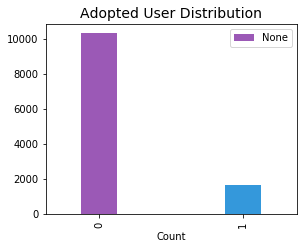

------Adopted User Statistics -------
Adopted User Counts: 
0    10344
1     1656
Name: adopted_user, dtype: int64

Adopted User Percentage: 
0    0.862
1    0.138
Name: adopted_user, dtype: float64



In [88]:
# Plot the targt fearures `Adopted User `
plt.figure(figsize = (4.5,3.5))
user_new.groupby('adopted_user').size().plot(kind='bar', width=0.25, color=['#9b59b6', '#3498db'], legend= True)
plt.title('Adopted User Distribution', fontdict={'fontsize':14})
plt.xlabel('Count')
plt.show()  


# Print the adopted_user counts and percentage
print("------Adopted User Statistics -------")
print("Adopted User Counts: \n{}\n".format(user.adopted_user.value_counts()))
print("Adopted User Percentage: \n{}\n".format(user.adopted_user.value_counts(normalize = True)))

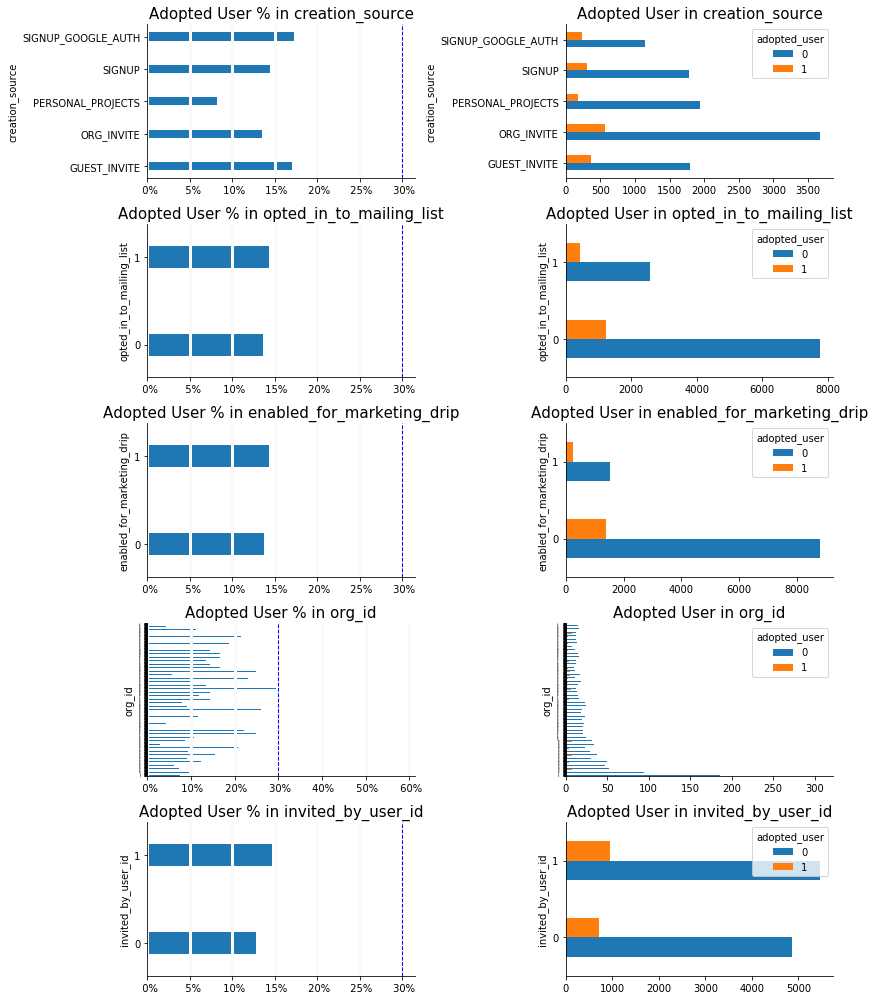

In [95]:
# visualize the catrgoty feature
cols = ['creation_source', "opted_in_to_mailing_list", "enabled_for_marketing_drip", "org_id", "invited_by_user_id"]
fig = plt.figure(figsize = (12,14))
y_size = [10, 10, 10, 0.5, 10]

i = 1
k = 0
for col in cols:
    crosstab = pd.crosstab([user_new[col]], user_new.adopted_user).apply(lambda r: 100*r/r.sum(), axis=1)
    ax = fig.add_subplot(5,2,i)
    crosstab.iloc[:,1].plot.barh(width = 0.25 , ax= ax)
    ax.grid(True, which='major', axis='x', color=(250/255.0, 250/255.0, 250/255.0), linewidth=3, zorder=1)
    ax.axvline(x=30, color="blue", linestyle='--', linewidth=1)
    vals = ax.get_xticks()
    ax.set_xticklabels(['{:3.0f}%'.format(x) for x in vals])
    ax.set_title('Adopted User % in '+ col, fontdict={'fontsize':15})
    ax.tick_params(axis="y", labelsize=y_size[k])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    i += 2
    k += 1

 
    
j = 2
m = 0
for col in cols:
    crosstab = pd.crosstab(user_new[col], user_new.adopted_user) 
    ax = fig.add_subplot(5,2,j)
    crosstab.plot.barh(stacked=False, legend=True, ax=ax )
    ax.set_title('Adopted User in '+ col, fontdict={'fontsize':15})
    ax.tick_params(axis="y", labelsize=y_size[m])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    j += 2
    m += 1


    
plt.tight_layout()
plt.show()

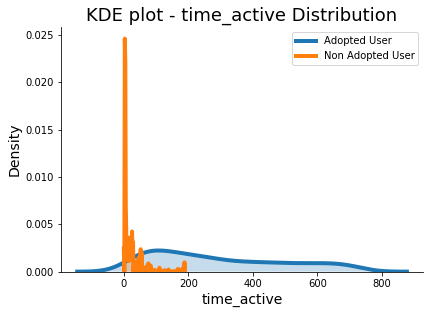

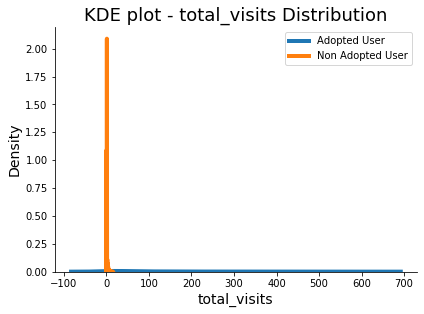

In [109]:
def kde_plot(col):
    fig = plt.figure(figsize = (6.5,4.5))
    #sns.kdeplot(data=telco.loc[:,col],label = 'Total', linewidth=4)
    ax = sns.kdeplot(data=user_new.loc[:,col][user_new.adopted_user == 1], 
                     label = 'Adopted User', linewidth=4, shade=True)
    ax = sns.kdeplot(data=user_new.loc[:,col][user_new.adopted_user == 0],
                     label = 'Non Adopted User',linewidth=4, shade=True)
    plt.xlabel(col, fontdict={'fontsize':14})
    plt.ylabel('Density', fontdict={'fontsize':14})
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.title("KDE plot - "+col+ " Distribution",fontdict={'fontsize':18})
    plt.show()
    
    
numeric_features =  ['time_active', 'total_visits']

for col in numeric_features:   
    kde_plot(col)
    

## 3.3 Machine Learning Modeling

In [111]:
from imblearn.pipeline import Pipeline as pl
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, precision_recall_curve, cohen_kappa_score
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split, GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from yellowbrick.classifier import DiscriminationThreshold

Using TensorFlow backend.


### 3.3.1 Data Preprocessing

In [146]:
# define plot function
#Define the plot Function
def result(model, X_train, y_train, X_test, y_test, train_result, clf_name):
    """ This function calculates different metrics to show the model's performance on both training and test data.
    This functoin also shows the confusion matrix, and plots the ROC and PR curves.
    
    Parameters
    ----------
    model (dtype: sklearn.model_selection._search.GridSearchCV) : The classifier model
    train_result (dtype: boolean): If YES, calculate results for train data
    clf_name (dtype: str): Name of the classifier
    """
    if train_result:
        y_pred_train = model.predict(X_train) # class prediction
        y_pred_train_prob = model.predict_proba(X_train) # probability of each class prediction
        print("#######################################")
        print("Evaluation Metrics for %s" % clf_name)
        print("#######################################")
        print("F1: ", metrics.f1_score(y_train, y_pred_train))
        print("Cohen Kappa: ", metrics.cohen_kappa_score(y_train, y_pred_train))
        print("Brier: ", metrics.brier_score_loss(y_train, y_pred_train))
        print("LogLoss: ", metrics.log_loss(y_train, y_pred_train_prob))
        print(metrics.classification_report(y_train, y_pred_train))
        print(metrics.confusion_matrix(y_train, y_pred_train))
    else:
        pass
    
    y_pred_test = model.predict(X_test)
    y_pred_test_prob = model.predict_proba(X_test)
    print("#######################################")
    print("Evaluation Metrics for %s" % clf_name )
    print("#######################################")
    print("F1: ", metrics.f1_score(y_test, y_pred_test))
    print("Cohen Kappa: ", metrics.cohen_kappa_score(y_test, y_pred_test))
    print("Brier: ", metrics.brier_score_loss(y_test, y_pred_test))
    print("LogLoss: ", metrics.log_loss(y_test, y_pred_test_prob))
    print(metrics.classification_report(y_test, y_pred_test))
    conf_matrix = metrics.confusion_matrix(y_test, y_pred_test)
    
    fig = plt.figure(figsize = (20,6))
    # Displaying the confusion matrix
    ax = fig.add_subplot(1,3,1)
    #fig, ax = plt.subplots(figsize=(8, 8))
    ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i, s=conf_matrix[i, j], va='center', ha='center', fontsize=24)

    ax.set_title('Confusion Matrix', size=15)
    ax.set_xlabel('Predicted label', size=15)
    ax.set_ylabel('True label', size=15)
    ax.tick_params('x', labelsize = 15)
    ax.tick_params('y', labelsize = 15)
    #plt.tight_layout()
    
    # ROC curve
    ax = fig.add_subplot(1,3,2)
    #fig1, ax1 = plt.subplots(figsize=(8, 8))
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_test_prob[:, 1])
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, lw=1, label='Model Performance (area = %0.2f)' % (roc_auc))
    ax.plot([0, 1], 
             [0, 1], 
             '--', 
             color=(0.6, 0.6, 0.6), 
             label='Luck')
    
    ax.plot([0, 0, 1], 
             [0, 1, 1], 
             lw=2,
             linestyle=':',
             color='black',
             label='Perfect Performance')
        
    ax.set_xlim([-0.02, 1.02])
    ax.set_ylim([-0.02, 1.02])
    ax.set_xlabel('False Positive Rate', size=15)
    ax.set_ylabel('True Positive Rate', size=15)
    ax.set_title('Receiver Operating Characteristic', size=15)
    ax.tick_params('x', labelsize = 15)
    ax.tick_params('y', labelsize = 15)
    plt.legend(loc="lower right", fontsize=18)
    
    # PR curve
    ax = fig.add_subplot(1,3,3)
    #fig2, ax2 = plt.subplots(figsize=(8, 8))
    prec, recall, thresholds = precision_recall_curve(y_test, y_pred_test_prob[:, 1])
    #pr_auc = auc(prec, recall)
    ax.plot(recall, prec, lw=1, label='Model Performance (area = %0.2f)' % 
             (metrics.average_precision_score(y_test, y_pred_test_prob[:, 1])))    
    ax.set_xlim([-0.02, 1.02])
    ax.set_ylim([-0.02, 1.02])
    ax.set_xlabel('Recall', size=15)
    ax.set_ylabel('Precision', size=15)
    ax.set_title('PR Curve', size=15)
    ax.tick_params('x', labelsize = 15)
    ax.tick_params('y', labelsize = 15)
    plt.legend(loc="top right", fontsize=15)
    plt.tight_layout()
          


In [124]:
# processing data to use
feature_to_use = user_new.drop(['creation_time','name','email','last_session_creation_time',], axis=1)

for item in feature_to_use:
    if item != "creation_source":
        feature_to_use[col] = feature_to_use[col].astype('int')
        
feature_to_use_transfmd = pd.get_dummies(feature_to_use)
X = feature_to_use_transfmd.drop(["adopted_user"], axis=1).values
y = feature_to_use_transfmd.adopted_user.values

# train-test split by stratificaiton
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

### 3.3.1 Random Forest

#### Baseline Random Forest Model

In [128]:
# Steps for pipeline
steps = [("scaler", MinMaxScaler(feature_range=(0,1))),
         ("model", RandomForestClassifier(random_state=40))]
pipe = pl(steps)

# Parameters
param_grid = dict(model__n_estimators = [50, 70, 100, 200, 500, 700, 1000],
                  model__max_features = ['sqrt', 'log2'],
                  model__min_samples_leaf = [1, 5, 10, 20, 30])

# For CV in grid search
cv = StratifiedShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 20)

# Setting up the grid search
RFcw = GridSearchCV(pipe, 
                    param_grid = param_grid, 
                    verbose = 3,
                    cv = cv,
                    n_jobs=-1,
                    scoring='average_precision',
                    iid=False)

# Training using CV
RFcw.fit(X_train, y_train)

Fitting 5 folds for each of 70 candidates, totalling 350 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed: 26.0min
[Parallel(n_jobs=-1)]: Done 350 out of 350 | elapsed: 31.5min finished


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=20, test_size=0.2,
            train_size=None),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        MinMaxScaler(copy=True,
                                                     feature_range=(0, 1))),
                                       ('model',
                                        RandomForestClassifier(bootstrap=True,
                                                               ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_node...
         

In [145]:
RFcw.best_params_

{'model__max_features': 'sqrt',
 'model__min_samples_leaf': 1,
 'model__n_estimators': 1000}

#######################################
Evaluation Metrics for RF, Baseline
#######################################
F1:  0.9422492401215805
Cohen Kappa:  0.9330753210843559
Brier:  0.015833333333333335
LogLoss:  0.03414354197096044
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2069
           1       0.95      0.94      0.94       331

    accuracy                           0.98      2400
   macro avg       0.97      0.96      0.97      2400
weighted avg       0.98      0.98      0.98      2400



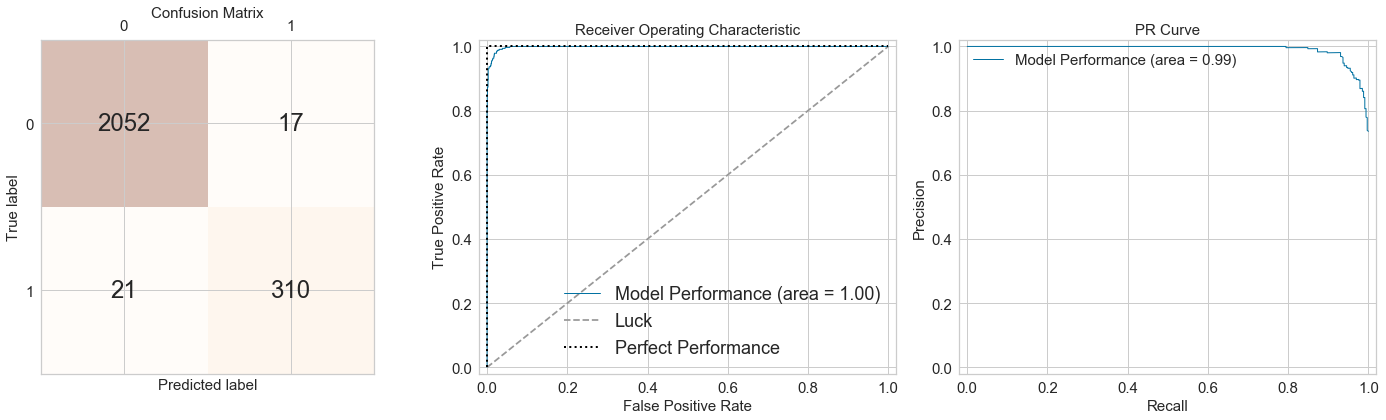

In [147]:
result(RFcw, X_train, y_train, X_test, y_test, train_result=False, clf_name="RF, Baseline")

#### Random Forest Model with SMOTE

In [148]:
# Steps for pipeline
steps = [("smote", SMOTE(random_state=30)),
         ("scaler",MinMaxScaler(feature_range=(0,1))),
         ("model", RandomForestClassifier(random_state=40))]
pipe = pl(steps)

# Parameters
param_grid = dict(model__n_estimators = [1000],
                  model__max_features = ['sqrt'],
                  model__min_samples_leaf = [1])

# For CV in grid search
cv = StratifiedShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 20)

# Setting up the grid search
RFsmote = GridSearchCV(pipe, 
                       param_grid = param_grid, 
                       verbose = 4,
                       cv = cv,
                       n_jobs=-1,
                       scoring='average_precision',
                       iid=False)

# Training using CV
RFsmote.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  4.1min remaining:  6.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.6min finished


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=20, test_size=0.2,
            train_size=None),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('smote',
                                        SMOTE(k_neighbors=5, n_jobs=None,
                                              random_state=30,
                                              sampling_strategy='auto')),
                                       ('scaler',
                                        MinMaxScaler(copy=True,
                                                     feature_range=(0, 1))),
                                       ('model',
                                        RandomForestClassifier(bootstrap=True,
                                                               ccp_alpha=0.0...
                                                               min_weight_fraction_leaf=0.0,
                                                            

#######################################
Evaluation Metrics for RF, SMOTE
#######################################
F1:  0.9392592592592592
Cohen Kappa:  0.9293241550501626
Brier:  0.017083333333333332
LogLoss:  0.038107487682636026
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2069
           1       0.92      0.96      0.94       331

    accuracy                           0.98      2400
   macro avg       0.96      0.97      0.96      2400
weighted avg       0.98      0.98      0.98      2400



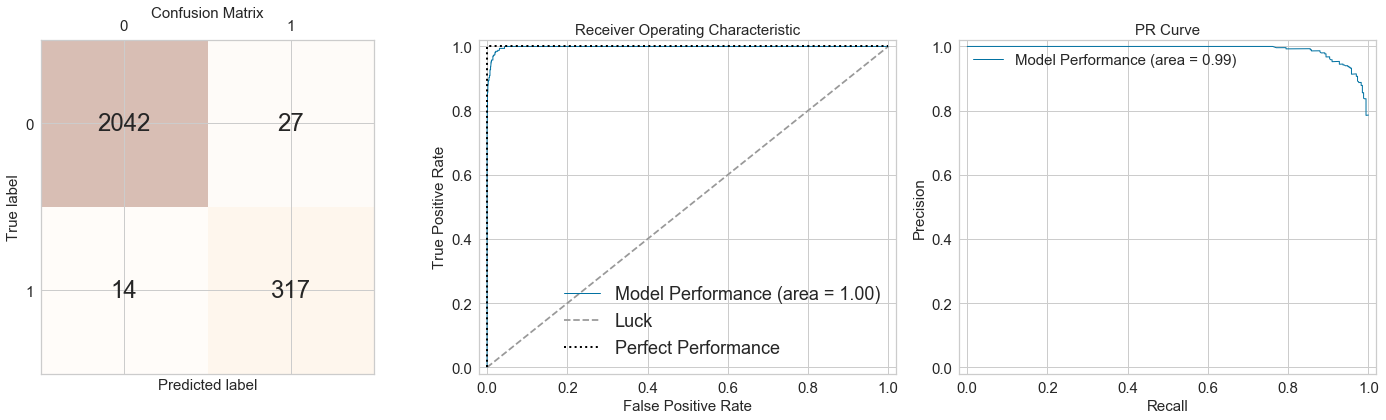

In [149]:
result(RFsmote, X_train, y_train, X_test, y_test, train_result=False, clf_name="RF, SMOTE")

In [166]:
# refit the smote 
param_grid = {'n_estimators': [1000]}
rf = RandomForestClassifier(max_features = 'sqrt',
                            min_samples_leaf  = 1,
                            random_state=40)
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf,
                           param_grid = param_grid,
                           cv = 3, 
                           n_jobs = -2, 
                           verbose = 2,
                           return_train_score = True)
                           

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

best_grid = grid_search.best_estimator_
feature_results = pd.DataFrame({'feature': list(feature_to_use_transfmd.drop(["adopted_user"], axis=1).columns), 
                                'importance': best_grid.feature_importances_})

# Show the top most important
feature_results = feature_results.sort_values('importance', ascending = False).reset_index(drop=True)
print(feature_results)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done   3 out of   3 | elapsed:  1.3min finished


                               feature  importance
0                         total_visits    0.551923
1                          time_active    0.401823
2                               org_id    0.031702
3             opted_in_to_mailing_list    0.002938
4    creation_source_PERSONAL_PROJECTS    0.002244
5           enabled_for_marketing_drip    0.002191
6           creation_source_ORG_INVITE    0.001654
7         creation_source_GUEST_INVITE    0.001653
8               creation_source_SIGNUP    0.001340
9                   invited_by_user_id    0.001336
10  creation_source_SIGNUP_GOOGLE_AUTH    0.001196


# 4. Business Key Takeaways

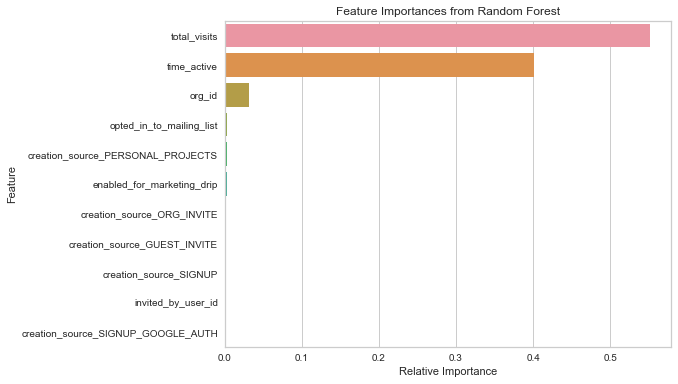

In [168]:
#plot the feature imortance
plt.figure(figsize=(8, 6))
sns.barplot(x='importance', y='feature', 
            data=feature_results)
plt.xlabel('Relative Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from Random Forest')
plt.show()

>> 1. Both the Random Forest Baseline Model and the Random Forest SMOTE Model return the results that closed to a perfect prediction performance. However, there's a slightly difference between the two models - the trade-off between the precision and recall. The baseline model has a slightly better precision whereas SMOTE holds the recall. Noted that if we want to capture all the adopted users and we have tolerance for don;t want to missing any adopted user cases - we stick to the SMOTE model. On the other hand, if we want to capture all the adopted users and we want to maintain the only true adopted users to reduce the unnecessary cost for any non-adopted users the model may predict - we will go with the baseline model.
>> 2. The Top 3 important features in our prediction model - total visits, time active and the organization (group of users) they belong to - are three important features that stand out, which means in the long run platform monitoring, these should be a top priority that we will be looking at for insights.